# ML Classifiers

## Imports

In [2]:
%matplotlib inline

import sys

import numpy as np

import pandas as pd

import sklearn as skl
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.neighbors import KNeighborsClassifier

# Metrics

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay

# Tuning

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt

**Local:**

In [3]:
sys.path.insert(1, './../')

import ana
import plotting
import labbook

**Version:**

In [4]:
print(f'Python {sys.version}\n')
print(f'NumPy {np.__version__}')
print(f'Sci-kit Learn {skl.__version__}')

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

NumPy 1.26.4
Sci-kit Learn 1.4.0


## Configuration

In [5]:
config = {
    'Cuts': [
        'Detector Quality',
        'Data Quality',
        'Cosmic Rej.',
        'Veto',
        'CVN PID Score',
        'Not Containment'
    ],
    'Transforms': [
        'tf_290124_positive_energies',
        'tf_290124_valid_pid',
        'tf_280224_encode_event_type',
        'tf_280224_class_balance'
    ],
    'TestingTransforms': [
        'tf_290124_positive_energies',
        'tf_290124_valid_pid',
        'tf_120224_first_prong',
        'tf_280224_encode_event_type'
    ],
    'XDataCols': [
        # Loose pre-selection IDs
        'rec.sel.cvnloosepreselptp.cosmicid',
        'rec.sel.cvnloosepreselptp.ncid',
        'rec.sel.cvnloosepreselptp.numuid',
        # REM and SCP IDs
        'rec.sel.remid.pid',
        'rec.sel.scann.scpid',
        # Muon energies
        'rec.energy.numu.lstmmuon'
    ],
    'YDataCols': [
        'ana.cat.event_type'
    ]
}

## Loading training dataset

In [6]:
ds = ana.Datasets()

Datasets | Found the following: MINI_DATA_DIR, DATA_V2_DIR, DATA_V3_DIR, REALLY_MINI_DIR, COPYMERGED_C8_DIR, COPYMERGED_C9_DIR, COPYMERGED_C10_DIR, COPYMERGED_C11_DIR, COPYMERGED_C13_DIR, COPYMERGED_C15_DIR, COPYMERGED_C16_DIR, COPYMERGED_C17_DIR, COPYMERGED_C19_DIR, COPYMERGED_C20_DIR, COPYMERGED_C21_DIR, COPYMERGED_C22_DIR


In [7]:
data = ana.NOvAData.init_from_copymerge_h5(
    h5dirs=[
        ds.COPYMERGED_C8_DIR,  # type: ignore
        ds.COPYMERGED_C9_DIR,  # type: ignore
        ds.COPYMERGED_C10_DIR,  # type: ignore
        ds.COPYMERGED_C11_DIR,  # type: ignore
        ds.COPYMERGED_C13_DIR,  # type: ignore
        ds.COPYMERGED_C15_DIR,  # type: ignore
        ds.COPYMERGED_C16_DIR  # type: ignore
    ]
)

NOvAData | Loading tables from copymerged HDF5 files...
NOvAData | Loaded table from copymerged HDF5 files (1 / 7).
NOvAData | Loaded table from copymerged HDF5 files (2 / 7).
NOvAData | Loaded table from copymerged HDF5 files (3 / 7).
NOvAData | Loaded table from copymerged HDF5 files (4 / 7).
NOvAData | Loaded table from copymerged HDF5 files (5 / 7).
NOvAData | Loaded table from copymerged HDF5 files (6 / 7).
NOvAData | Loaded table from copymerged HDF5 files (7 / 7).
NOvAData | Initialised NOvAData(features=54, events=1_094_528).


In [8]:
data.fill_ana_flags(inplace=True)
data.fill_ana_track_kinematics(inplace=True)
data.fill_categorical(inplace=True)

NOvAData | Filled MC truth flags.
NOvAData | Filled track kinematics.
NOvAData | Filled categorical data.


In [9]:
cuts = ana.Cuts.init_nova_cuts()

In [10]:
# Cuts
data.table = cuts.apply_cuts(config['Cuts'][:-1], data.table)
data.table = cuts.apply_cut('Containment', data.table, passed=False)


Cuts     | Applied 'Detector Quality' cut (1_094_528 -> 919_711 events).
Cuts     | Applied 'Data Quality' cut (919_711 -> 919_688 events).
Cuts     | Applied 'Cosmic Rej.' cut (919_688 -> 351_421 events).
Cuts     | Applied 'Veto' cut (351_421 -> 313_034 events).
Cuts     | Applied 'CVN PID Score' cut (313_034 -> 196_427 events).
Cuts     | Applied 'Containment' cut (196_427 -> 105_055 events).


In [11]:
# Transforms
data.apply_transforms(config['Transforms'], inplace=True)

NOvAData | Applied a transform which cuts out the negative energies caused by issues with the reco. models.
NOvAData | Applied a transform which ensures that the PID score is between 0 and 1.
NOvAData | Applied a transform which encodes the event type as 1 for (A-)NuMu CC and 0 for background.
NOvAData | Applied a transform which balances the number of events for each class.


In [12]:
data.table.head()

rec.energy.numu.E  \
run   subrun cycle batch evt subevt                      
14746 41     0     0     173 1                0.822706   
                         652 1                0.822706   
14750 20     0     0     699 1                1.001116   
                         793 2                2.867611   
14754 16     0     0     461 2                1.859418   

                                     rec.energy.numu.calccE  \
run   subrun cycle batch evt subevt                           
14746 41     0     0     173 1                     0.816658   
                         652 1                     0.816658   
14750 20     0     0     699 1                     1.070769   
                         793 2                     3.288869   
14754 16     0     0     461 2                     1.658546   

                                     rec.energy.numu.hadcalE  \
run   subrun cycle batch evt subevt                            
14746 41     0     0     173 1                      0.004180   
                         652 1                      0.004180   
14750 20     0     0     699 1                      0.190039   
                         793 2                      0.728458   
14754 16     0     0     461 2                      0.022085   

                                     rec.energy.numu.hadtrkE  \
run   subrun cycle batch evt subevt                            
14746 41     0     0     173 1                      0.009910   
                         652 1                      0.009910   
14750 20     0     0     699 1                      0.024564   
                         793 2                      0.010688   
14754 16     0     0     461 2                      0.007007   

                                     rec.energy.numu.lstmmuon  \
run   subrun cycle batch evt subevt                             
14746 41     0     0     173 1                       0.787001   
                         652 1                       0.787001   
14750 20     0     0     699 1                       0.554846   
                         793 2                       2.563976   
14754 16     0     0     461 2                       1.886155   

                                     rec.energy.numu.lstmnu  \
run   subrun cycle batch evt subevt                           
14746 41     0     0     173 1                     0.870839   
                         652 1                     0.870839   
14750 20     0     0     699 1                     0.997018   
                         793 2                     3.151421   
14754 16     0     0     461 2                     2.024810   

                                     rec.energy.numu.regcvnhadE  \
run   subrun cycle batch evt subevt                               
14746 41     0     0     173 1                         0.074651   
                         652 1                         0.074651   
14750 20     0     0     699 1                         0.612823   
                         793 2                         0.924363   
14754 16     0     0     461 2                         0.094978   

                                     rec.energy.numu.trkccE  \
run   subrun cycle batch evt subevt                           
14746 41     0     0     173 1                     0.822706   
                         652 1                     0.822706   
14750 20     0     0     699 1                     1.001116   
                         793 2                     2.867611   
14754 16     0     0     461 2                     1.859418   

                                     rec.energy.numu.recomuonE  \
run   subrun cycle batch evt subevt                              
14746 41     0     0     173 1                        0.783632   
                         652 1                        0.783632   
14750 20     0     0     699 1                        0.560385   
                         793 2                        1.465072   
14754 16     0     0     461 2                        1.790292   

                 

In [13]:
std_scaler = StandardScaler()

scale_vars = [
    'rec.energy.numu.lstmmuon'
]

In [14]:
tt_split = data.train_test_split(
    x_cols=config['XDataCols'],
    y_cols=config['YDataCols'],
    test_size=0.3
)

tt_split['XTrain'].loc[:, scale_vars] = std_scaler.fit_transform(
    tt_split['XTrain'][scale_vars]
)
tt_split['XTest'].loc[:, scale_vars] = std_scaler.transform(
    tt_split['XTest'][scale_vars]
)
tt_split['YTrain'] = tt_split['YTrain'].to_numpy().flatten()
tt_split['YTest'] = tt_split['YTest'].to_numpy().flatten()

## Loading testing dataset

In [15]:
test_data = ana.NOvAData.init_from_copymerge_h5(
    h5dirs=[
        ds.COPYMERGED_C19_DIR,  # type: ignore
        ds.COPYMERGED_C20_DIR,  # type: ignore
        ds.COPYMERGED_C21_DIR,  # type: ignore
        ds.COPYMERGED_C22_DIR  # type: ignore
    ]
)

NOvAData | Loading tables from copymerged HDF5 files...
NOvAData | Loaded table from copymerged HDF5 files (1 / 4).
NOvAData | Loaded table from copymerged HDF5 files (2 / 4).
NOvAData | Loaded table from copymerged HDF5 files (3 / 4).
NOvAData | Loaded table from copymerged HDF5 files (4 / 4).
NOvAData | Initialised NOvAData(features=54, events=671_350).


In [16]:
test_data.fill_ana_flags(inplace=True)
test_data.fill_categorical(inplace=True)
test_data.fill_ana_track_kinematics(inplace=True)

NOvAData | Filled MC truth flags.
NOvAData | Filled categorical data.
NOvAData | Filled track kinematics.


In [17]:
test_data.apply_transforms(config['TestingTransforms'], inplace=True)

NOvAData | Applied a transform which cuts out the negative energies caused by issues with the reco. models.
NOvAData | Applied a transform which ensures that the PID score is between 0 and 1.
NOvAData | Applied a transform which only keeps data for the first prong.
NOvAData | Applied a transform which encodes the event type as 1 for (A-)NuMu CC and 0 for background.


In [18]:
# Cuts
fail_cont_table = cuts.apply_cuts(config['Cuts'][:-1], test_data.table)
fail_cont_table = cuts.apply_cut('Containment', fail_cont_table, passed=False)

Cuts     | Applied 'Detector Quality' cut (275_579 -> 264_421 events).
Cuts     | Applied 'Data Quality' cut (264_421 -> 264_421 events).
Cuts     | Applied 'Cosmic Rej.' cut (264_421 -> 149_447 events).
Cuts     | Applied 'Veto' cut (149_447 -> 141_050 events).
Cuts     | Applied 'CVN PID Score' cut (141_050 -> 95_669 events).
Cuts     | Applied 'Containment' cut (95_669 -> 47_822 events).


In [19]:
# Cuts
full_cut_table = cuts.apply_all_cuts(test_data.table)

Cuts     | Applied 'Detector Quality' cut (275_579 -> 264_421 events).
Cuts     | Applied 'Data Quality' cut (264_421 -> 264_421 events).
Cuts     | Applied 'CVN PID Score' cut (264_421 -> 101_766 events).
Cuts     | Applied 'Containment' cut (101_766 -> 48_577 events).
Cuts     | Applied 'Cosmic Rej.' cut (48_577 -> 47_955 events).
Cuts     | Applied 'Veto' cut (47_955 -> 47_847 events).


In [20]:
x_test_data = fail_cont_table[config['XDataCols']]
y_test_data = fail_cont_table[config['YDataCols']].to_numpy()

In [21]:
x_test_data.loc[:, scale_vars] = std_scaler.transform(x_test_data[scale_vars])

C:\Users\Shrey\AppData\Local\Temp\ipykernel_3148\1053093416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_data.loc[:, scale_vars] = std_scaler.transform(x_test_data[scale_vars])


## Model

In [22]:
bdt_params = {
    'ccp_alpha': 0.0,
    'criterion': 'friedman_mse',
    'init': None,
    'learning_rate': 0.1,
    'loss': 'log_loss',
    'max_depth': 3,
    'max_features': None,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 100,
    'n_iter_no_change': None,
    'random_state': None,
    'subsample': 1.0,
    'tol': 0.0001,
    'validation_fraction': 0.1,
    'verbose': 0,
    'warm_start': False
}

rf_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': None,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'monotonic_cst': None,
    'n_estimators': 100,
    'n_jobs': None,
    'oob_score': False,
    'random_state': None,
    'verbose': 0,
    'warm_start': False
}

ada_params = {
    'algorithm': 'SAMME',
    # 'estimator': None,
    'learning_rate': 1E-3,
    'n_estimators': 50,
}


In [23]:
# model = GradientBoostingClassifier(**bdt_params)
# model = RandomForestClassifier(**rf_params)
# model = AdaBoostClassifier(**ada_params)
model = BaggingClassifier(
    estimator=KNeighborsClassifier(n_neighbors=5),
    n_estimators=10
)

In [24]:
model = model.fit(
    X=tt_split['XTrain'].to_numpy(),
    y=tt_split['YTrain']
)

In [25]:
bdt_param_distribution = {
    'ccp_alpha': [0, 10, 20, 40, 80, 100],
    'criterion': ['friedman_mse', 'squared_error'],
    'learning_rate': [1E-4, 1E-3, 1E-2, 1E-1, 1.],
    'loss': ['log_loss', 'exponential'],
    'max_depth': [i for i in range(1, 510, 10)],
    'max_features': ['sqrt', 'log2'] + [
        i for i in range(1, len(config['XDataCols']) + 1, 1)
    ],
    'max_leaf_nodes': [None] + [i for i in range(50, 510, 10)],
    'min_impurity_decrease': [
        0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0
    ],
    'min_samples_leaf': [i for i in range(1, 210, 10)],
    'min_samples_split': [i for i in range(2, 300, 100)],
    'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [i for i in range(100, 1_000, 100)],
    'subsample': [0.1, 0.2, 0.4, 0.8, 1.0]  # --> Reduces variance but increases bias...
}

rf_param_distribution = {
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None] + [i for i in range(1, 510, 10)],
    'max_features': ['sqrt', 'log2'] + [
        i for i in range(1, len(config['XDataCols']) + 1, 1)
    ],
    'max_leaf_nodes': [None] + [i for i in range(50, 510, 10)],
    'min_impurity_decrease': [
        0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0
    ],
    'min_samples_leaf': [i for i in range(1, 210, 10)],
    'min_samples_split': [i for i in range(2, 300, 100)],
    'n_estimators': [i for i in range(100, 1_000, 100)]
}

In [26]:
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=rf_param_distribution,
#     n_iter=10,
#     scoring='precision',
#     n_jobs=-1,
#     refit=True
# )

In [27]:
# rs_result = random_search.fit(
#    X=tt_split['XTrain'].to_numpy(),
#    y=tt_split['YTrain']
#)

In [28]:
# rs_result.best_score_

In [29]:
# model = rs_result.best_estimator_
# model

## Analysis

In [30]:
y_predicted = model.predict(x_test_data.to_numpy())

In [31]:
ana_kwargs = {'y_true': y_test_data, 'y_pred': y_predicted}

Accuracy = 0.47674710384341934
Precision = 0.9913093858632677
Recall = 0.4725414798920779


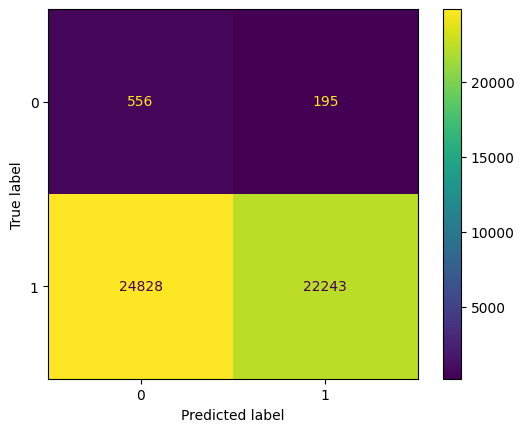

In [32]:
acc = accuracy_score(**ana_kwargs)
pre = precision_score(**ana_kwargs)
rec = recall_score(**ana_kwargs)

cm = confusion_matrix(**ana_kwargs)

print('Accuracy =', acc)
print('Precision =', pre)
print('Recall =', rec)

ConfusionMatrixDisplay(cm).plot();

In [33]:
cm[0, 1] * 100 / (cm[1, 1] + cm[0, 1])

0.8690614136732329

In [59]:
pd_y_predicted = pd.Series(
    y_predicted,
    index=fail_cont_table.index
)
pd_y_test_data = pd.Series(
    y_test_data.flatten(),
    index=fail_cont_table.index
)
is_correct = pd.Series(
    1 * (pd_y_predicted == pd_y_test_data),
    index=fail_cont_table.index
)

In [78]:
column = 'rec.energy.numu.lstmnu'
e_bins = np.linspace(0, 10, 100 + 1)
accuracy_arr = []
precision_arr = []
cents = []

for i in range(100):
    bin_data = fail_cont_table[
        (fail_cont_table[column] > e_bins[i])
        & (fail_cont_table[column] <= e_bins[i + 1])
    ]

    bin_is_correct = is_correct[bin_data.index]

    corr_count = len(bin_is_correct[bin_is_correct > 0])
    wrng_count = len(bin_is_correct[bin_is_correct < 1])

    if wrng_count:
        accuracy_arr.append(corr_count / (corr_count + wrng_count))
    else:
        accuracy_arr.append(1.)

    bin_y_predicted = pd_y_predicted[bin_data.index]
    bin_y_test_data = pd_y_test_data[bin_data.index]

    tp = len(bin_y_predicted[
        (bin_y_predicted == 1) & (bin_y_test_data == 1)
    ])
    tp_fp = len(bin_y_predicted[bin_y_predicted == 1])

    if tp_fp:
        precision_arr.append(tp / tp_fp)
    else:
        precision_arr.append(1.)

    cents.append((e_bins[i] + e_bins[i + 1]) / 2)
 

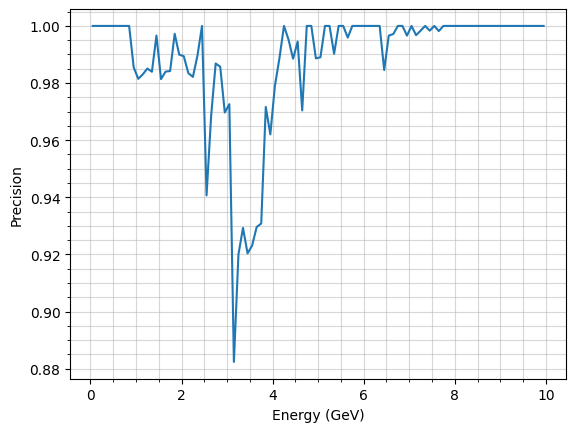

In [81]:
plt.minorticks_on() 
plt.grid(which='both', alpha=0.5)

# plt.bar(
#     cents, precision_arr,
#     e_bins[1] - e_bins[0],
#     edgecolor='purple', color='None'
# )

plt.plot(
    cents,
    precision_arr
)

plt.xlabel('Energy (GeV)')
plt.ylabel('Precision');

In [ ]:
try:
    feature_importances = pd.Series(
        model.feature_importances_,
        index=config['XDataCols']
    ).sort_values(ascending=False)
    feature_importances.plot.bar()
except AttributeError:
    pass

## Labbook

In [ ]:
# labbook.LabBookApplication('./../../labbook').mainloop()

In [ ]:
comments = f"""\
Classifier: Random Forest
-------------------------

No class balancing was attempted.

Found best hyperparameters using randomized grid search by maximising the \
precision.

The best hyperparameters were:
{rs_result.best_params_}

The best score (precision) was: {rs_result.best_score_}

The following variables were standardised:
{scale_vars}
"""

NameError: name 'rs_result' is not defined

In [ ]:
# labbook.add_log_skl(
#     comments=comments,
#     config_dict=config,
#     model=model,
#     lb_dir='./../../labbook',
#     serialise_objects={
#         'StandardScaler': std_scaler,
#         'ScaleVars': scale_vars
#     }
# )